Generate initial condition of single localized pulse for LLE continuation, both 2nd and 4th order

Based on code from Oliver Melchert and Ayhan Demircan, pyGLLE: A Python toolkit for solving the generalized Lugiato–Lefever equation. SoftwareX 15 (2021).

https://www.sciencedirect.com/science/article/pii/S235271102100073X
https://github.com/ElsevierSoftwareX/SOFTX_2020_88

Modification made in numerical method for root finding: split LLE up into real and imaginary parts. This allows for using a better root-finding method ('hybr').

In [82]:
# import os module
import os

# import AUTO modules
from auto import AUTOCommands as ac
from auto import AUTOclui as acl
from auto import interactiveBindings as ib
from auto import runAUTO as ra

# root finding, fftb
from scipy.optimize import root, fsolve, newton
import scipy.fftpack as sfft

# import plotting tools
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.io import savemat

In [95]:
# find guess for specific set of parameters
# these starting parameters are used for both 2nd and 4th order LLE equations
theta = 9.
P = 9.

# find square intensity of background state (CW) corresponding to these parameters
Iout = newton( lambda r : r*( 1 + (theta - r)**2 ) - P**2, np.abs(P/(theta+1j)) )
a = P / (1 + (Iout - theta)**2)
b = (Iout - theta)*P / (1 + (Iout - theta)**2)
print("a, b, norm, square intensity: ", a, b, np.sqrt(Iout), Iout)

a, b, norm, square intensity:  0.1518538878683173 -1.1591485614683443 1.1690530316520529 1.3666849908148557


In [102]:
# compute single pulse solution to LLE equation

# domain length and number of grid points
# for larger L, will need larger N
# (L,N) = (20,256) and (L,N) = (50,512) both work
L = 40       # domain length [-L, L]
N = 512      # number of grid points, should be power of 2 since using Fourier

# compute "guess" for single pulse, scaled for AUTO to interval [0,1]
# interval [0,1] with endpoint removed since periodic BCs
x = np.linspace(0, 1, N, endpoint=False)
# fourier frequencies
k = sfft.fftfreq(x.size,d=x[1]-x[0])*2*np.pi
# generate inital guess; this is from Melchert and Demircan (2021)
coszeta = np.sqrt(8*theta)/(P*np.pi)
sinzeta = np.sqrt(1-(coszeta**2))
xL = 2*L*x - L;
y = (a + 1j*b) + np.sqrt(2*theta)*( coszeta+1j*sinzeta ) / np.cosh(np.sqrt(theta)*xL)

# split guess into real and imaginary parts, and concatenate into single array
ysep = np.concatenate( (np.real(y), np.imag(y)) )

# scale factor for interval [-L,L]
scale = 2*L

# RHS of LLE equation, separated into real and imaginary parts
def LLE(u, P, theta, N, k, scale):
    a = u[:N]
    b = u[N:]
    amp = (a**2+b**2)
    d1 = -a - amp*b + theta*b - np.real( sfft.fft((-k**2)*sfft.ifft(b)) )/(scale**2) + P
    d2 = -b + amp*a - theta*a + np.real( sfft.fft((-k**2)*sfft.ifft(a)) )/(scale**2)
    return( np.concatenate( (d1, d2)) )

# call root finding method
yout = root( lambda u : LLE(u,P,theta,N,k,scale), ysep, method='hybr' )

Starting LLE ...

  BR    PT  TY  LAB    PAR(1)        L2-NORM       MAX U(1)      MAX U(2)      MAX U(3)      MAX U(4)      PAR(3)     
   1     1  EP    1   9.00000E+00   1.55132E+00   1.49309E+00   4.81200E+00   2.43032E+00   9.17413E+00   0.00000E+00
   1     5        2   8.00238E+00   1.42077E+00   1.66011E+00   4.66201E+00   2.88787E+00   9.23775E+00  -3.49368E-09
   1    10  EP    3   7.92928E+00   1.41081E+00   1.67387E+00   4.65016E+00   2.90835E+00   9.19477E+00  -8.31348E-09

 Total Time    0.319E+00
LLE ... done


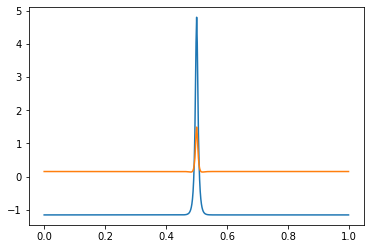

In [103]:
# real and imaginary parts of solution from root-finding
yr = yout.x[:N]
yi = yout.x[N:]

# plot our solution
plt.figure()
plt.plot( x, yi, x, yr )

# compute first derivatives
yrD = np.real( sfft.fft((1j*k)*sfft.ifft(yr)) / scale )
yiD = np.real( sfft.fft((1j*k)*sfft.ifft(yi)) / scale )

# save for AUTO (for 2nd order LLE)
np.savetxt('LLE.dat', np.transpose( (x,yr,yi,yrD,yiD) ) ) 

# test with AUTO

# start AUTO with runner object
runner = ra.runAUTO()
# run continuation for a few steps to make sure solution works with AUTO
rp = ac.run(e='LLE', c='LLE.1', runner=runner, NMX=10, PAR={1 : P, 2 : theta})


In [104]:
# RHS of LLE equation, separated into real and imaginary parts
def LLE4(u, P, theta, b2, b4, N, k, scale):
    a = u[:N]
    b = u[N:]
    amp = a**2+b**2
    d1 = -a - amp*b + theta*b + P \
            - b2*np.real( sfft.fft((-k**2)*sfft.ifft(b)) )/(scale**2) \
            - b4*np.real( sfft.fft((k**4)*sfft.ifft(b)) )/(scale**4)
    d2 = -b + amp*a - theta*a \
            + b2*np.real( sfft.fft((-k**2)*sfft.ifft(a)) )/(scale**2) \
            + b4*np.real( sfft.fft((k**4)*sfft.ifft(a)) )/(scale**4)
    return( np.concatenate( (d1, d2)) )

# for pure quartic, take b2=0, b4=-1
b2 = 0
b4 = -1

# call root finding method
yout2 = root( lambda u : LLE4(u,P,theta,b2,b4,N,k,scale), yout.x, method='hybr'  )

gfortran -fopenmp -O -c LLE4.f90 -o LLE4.o
gfortran -fopenmp -O LLE4.o -o LLE4.exe /auto/lib/*.o
Starting LLE4 ...

  BR    PT  TY  LAB    PAR(1)        L2-NORM       MAX U(1)      MAX U(2)      MAX U(3)      MAX U(4)      MAX U(5)      PAR(3)     
   1     1  EP    1   9.00000E+00   2.37212E+00   1.53534E+00   4.16601E+00   1.10042E+00   3.75927E+00   9.72413E-01   0.00000E+00
   1     3  BP    2   8.88681E+00   2.36761E+00   1.55049E+00   4.15426E+00   1.11306E+00   3.75430E+00   9.79484E-01   1.21209E-09
   1     8  BP    3   8.89481E+00   2.36893E+00   1.54935E+00   4.15495E+00   1.11222E+00   3.75599E+00   9.79016E-01   1.92725E-14
   1    10  EP    4   8.90851E+00   2.37120E+00   1.54765E+00   4.15689E+00   1.11093E+00   3.75866E+00   9.78035E-01   1.10803E-12

 Total Time    0.919E+00
LLE4 ... done


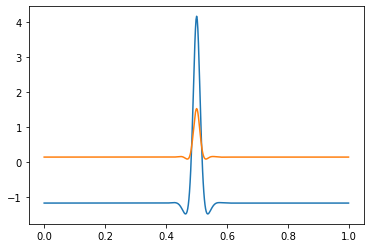

In [105]:
# real and imaginary parts of solution from root-finding
yr = yout2.x[:N]
yi = yout2.x[N:]

# plot our solution
plt.figure()
plt.plot( x, yi, x, yr )

# compute first three derivatives
yrD  = np.real( sfft.fft((1j*k)*sfft.ifft(yr)) / scale )
yiD  = np.real( sfft.fft((1j*k)*sfft.ifft(yi)) / scale )
yrD2 = np.real( sfft.fft((-k**2)*sfft.ifft(yr)) / (scale**2) )
yiD2 = np.real( sfft.fft((-k**2)*sfft.ifft(yi)) / (scale**2) )
yrD3 = np.real( sfft.fft((-1j*(k**3))*sfft.ifft(yr)) / (scale**3) )
yiD3 = np.real( sfft.fft((-1j*(k**3))*sfft.ifft(yi)) / (scale**3) )

# save for AUTO (for 2nd order LLE)
np.savetxt('LLE4.dat', np.transpose( (x,yr,yi,yrD,yiD,yrD2,yiD2,yrD3,yiD3) ) ) 

# test with AUTO

# start AUTO with runner object
runner = ra.runAUTO()
# run continuation for a few steps to make sure solution works with AUTO
rp = ac.run(e='LLE4', c='LLE4.1', runner=runner, NMX=10, PAR={1 : P, 2 : theta})